In [1]:
%matplotlib inline


# Tutorial 1: Simple Motor Imagery

In this example, we will go through all the steps to make a simple BCI
classification task, downloading a dataset and using a standard classifier. We
choose the dataset 2a from BCI Competition IV, a motor imagery task. We will
use a CSP to enhance the signal-to-noise ratio of the EEG epochs and a LDA to
classify these signals.


In [2]:
# Authors: Pedro L. C. Rodrigues, Sylvain Chevallier
#
# https://github.com/plcrodrigues/Workshop-MOABB-BCI-Graz-2019

import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import BNCI2014_001
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery


moabb.set_log_level("info")
warnings.filterwarnings("ignore")

## Instantiating Dataset

The first thing to do is to instantiate the dataset that we want to analyze.
MOABB has a list of many different datasets, each one containing all the
necessary information for describing them, such as the number of subjects,
size of trials, names of classes, etc.

The dataset class has methods for:

- downloading its files from some online source (e.g. Zenodo)
- importing the data from the files in whatever extension they might be
  (like .mat, .gdf, etc.) and instantiate a Raw object from the MNE package



In [3]:
dataset = BNCI2014_001()
#dataset.subject_list = [1, 2, 3]

## Accessing EEG Recording

As an example, we may access the EEG recording from a given session and a
given run as follows:



In [4]:
#dataset.allow_add_noise()
sessions = dataset.get_data(subjects=[1])
sessions

{1: {'0train': {'0': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '1': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '2': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '3': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '4': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '5': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>},
  '1test': {'0': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '1': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '2': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '3': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '4': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '5': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>}}}

This returns a MNE Raw object that can be manipulated. This might be enough
for some users, since the pre-processing and epoching steps can be easily
done via MNE. However, to conduct an assessment of several classifiers on
multiple subjects, MOABB ends up being a more appropriate option.



In [5]:
subject = 1
session_name = "0train"
run_name = "0"
raw = sessions[subject][session_name][run_name]
raw.get_data()

array([[ 3.41796875e-07, -6.34765625e-06, -1.80664062e-06, ...,
         2.92968750e-07, -6.34765625e-06, -9.71679687e-06],
       [ 2.44140625e-07, -7.95898437e-06, -7.17773437e-06, ...,
         4.88281250e-08, -5.12695312e-06, -7.17773437e-06],
       [-3.22265625e-06, -1.04980469e-05, -8.15429687e-06, ...,
        -3.07617188e-06, -9.71679687e-06, -1.39648438e-05],
       ...,
       [ 2.05078125e-05,  7.81250000e-06,  1.36718750e-05, ...,
         4.58984375e-05,  3.85742188e-05,  3.95507813e-05],
       [ 5.85937500e-06, -4.88281250e-06, -4.88281250e-07, ...,
        -4.39453125e-06, -4.39453125e-06, -1.07421875e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## Choosing a Paradigm

Once we have instantiated a dataset, we have to choose a paradigm. This
object is responsible for filtering the data, epoching it, and extracting
the labels for each epoch. Note that each dataset comes with the names of
the paradigms to which it might be associated. It would not make sense to
process a P300 dataset with a MI paradigm object.



In [6]:
print(dataset.paradigm)

imagery


For the example below, we will consider the paradigm associated to
left-hand/right-hand motor imagery task, but there are other options in
MOABB for motor imagery, P300 or SSVEP.



In [7]:
paradigm = LeftRightImagery()

We may check the list of all datasets available in MOABB for using with this
paradigm (note that BNCI2014_001 is in it)



In [8]:
print(paradigm.datasets)

[<moabb.datasets.bnci.BNCI2014_001 object at 0x17c7b4820>, <moabb.datasets.bnci.BNCI2014_004 object at 0x17c7b4580>, <moabb.datasets.gigadb.Cho2017 object at 0x17c7b40a0>, <moabb.datasets.mpi_mi.GrosseWentrup2009 object at 0x17c684f40>, <moabb.datasets.Lee2019.Lee2019_MI object at 0x10e4b1b80>, <moabb.datasets.liu2024.Liu2024 object at 0x10e4dbaf0>, <moabb.datasets.physionet_mi.PhysionetMI object at 0x10e4dbcd0>, <moabb.datasets.schirrmeister2017.Schirrmeister2017 object at 0x10e4dbdc0>, <moabb.datasets.bbci_eeg_fnirs.Shin2017A object at 0x10e4b1550>, <moabb.datasets.stieger2021.Stieger2021 object at 0x10e4db6a0>, <moabb.datasets.Weibo2014.Weibo2014 object at 0x10e4db8e0>, <moabb.datasets.Zhou2016.Zhou2016 object at 0x104c05fd0>]


The data from a list of subjects could be preprocessed and return as a 3D
numpy array `X`, follow a scikit-like format with the associated `labels`.
The `meta` object contains all information regarding the subject, the
session and the run associated to each trial.



In [9]:
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=[1])

## Create Pipeline

Our goal is to evaluate the performance of a given classification pipeline
(or several of them) when it is applied to the epochs from the previously
chosen dataset. We will consider a very simple classification pipeline in
which the dimension of the epochs are reduced via a CSP step and then
classified via a linear discriminant analysis.



In [10]:
pipeline = make_pipeline(CSP(n_components=8), LDA())

## Evaluation

To evaluate the score of this pipeline, we use the `evaluation` class. When
instantiating it, we say which paradigm we want to consider, a list with the
datasets to analyze, and whether the scores should be recalculated each time
we run the evaluation or if MOABB should create a cache file.

Note that there are different ways of evaluating a classifier; in this
example, we choose `WithinSessionEvaluation`, which consists of doing a
cross-validation procedure where the training and testing partitions are from
the same recording session of the dataset. We could have used
`CrossSessionEvaluation`, which takes all but one session as training
partition and the remaining one as testing partition.



In [11]:
evaluation = WithinSessionEvaluation(
    paradigm=paradigm,
    datasets=[dataset],
    overwrite=True,
    hdf5_path=None,
)

We obtain the results in the form of a pandas dataframe



In [12]:
results = evaluation.process({"csp+lda": pipeline})

2024-07-24 22:53:45,366 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-WithinSession:   0%|          | 0/9 [00:00<?, ?it/s]

No hdf5_path provided, models will not be saved.


2024-07-24 22:53:50,754 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 1 | 0train: Score 0.919


No hdf5_path provided, models will not be saved.


2024-07-24 22:53:53,818 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 1 | 1test: Score 0.956
BNCI2014-001-WithinSession:  11%|█         | 1/9 [00:08<01:08,  8.59s/it]

No hdf5_path provided, models will not be saved.


2024-07-24 22:53:58,845 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 2 | 0train: Score 0.607


No hdf5_path provided, models will not be saved.


2024-07-24 22:54:02,053 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 2 | 1test: Score 0.698
BNCI2014-001-WithinSession:  22%|██▏       | 2/9 [00:16<00:58,  8.36s/it]

No hdf5_path provided, models will not be saved.


2024-07-24 22:54:06,915 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 3 | 0train: Score 0.983


No hdf5_path provided, models will not be saved.


2024-07-24 22:54:10,030 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 3 | 1test: Score 0.996
BNCI2014-001-WithinSession:  33%|███▎      | 3/9 [00:24<00:49,  8.19s/it]

No hdf5_path provided, models will not be saved.


2024-07-24 22:54:15,322 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 4 | 0train: Score 0.823


No hdf5_path provided, models will not be saved.


2024-07-24 22:54:18,418 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 4 | 1test: Score 0.866
BNCI2014-001-WithinSession:  44%|████▍     | 4/9 [00:33<00:41,  8.28s/it]

No hdf5_path provided, models will not be saved.


2024-07-24 22:54:23,252 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 5 | 0train: Score 0.593


No hdf5_path provided, models will not be saved.


2024-07-24 22:54:26,380 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 5 | 1test: Score 0.593
BNCI2014-001-WithinSession:  56%|█████▌    | 5/9 [00:41<00:32,  8.16s/it]

No hdf5_path provided, models will not be saved.


2024-07-24 22:54:31,324 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 6 | 0train: Score 0.759


No hdf5_path provided, models will not be saved.


2024-07-24 22:54:34,381 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 6 | 1test: Score 0.724
BNCI2014-001-WithinSession:  67%|██████▋   | 6/9 [00:49<00:24,  8.11s/it]

No hdf5_path provided, models will not be saved.


2024-07-24 22:54:39,360 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 7 | 0train: Score 0.862


No hdf5_path provided, models will not be saved.


2024-07-24 22:54:42,410 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 7 | 1test: Score 0.977
BNCI2014-001-WithinSession:  78%|███████▊  | 7/9 [00:57<00:16,  8.08s/it]

No hdf5_path provided, models will not be saved.


2024-07-24 22:54:47,377 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 8 | 0train: Score 1.000


No hdf5_path provided, models will not be saved.


2024-07-24 22:54:50,387 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 8 | 1test: Score 0.994
BNCI2014-001-WithinSession:  89%|████████▉ | 8/9 [01:05<00:08,  8.05s/it]

No hdf5_path provided, models will not be saved.


2024-07-24 22:54:55,263 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 9 | 0train: Score 0.838


No hdf5_path provided, models will not be saved.


2024-07-24 22:54:58,336 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 9 | 1test: Score 0.967
BNCI2014-001-WithinSession: 100%|██████████| 9/9 [01:13<00:00,  8.12s/it]


The results are stored in locally, to avoid recomputing the results each time.
It is saved in `hdf5_path` if defined or in ~/mne_data/results  otherwise.
To export the results in CSV:



In [13]:
results

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.919320,0.607638,144.0,1,0train,22,2,BNCI2014-001,csp+lda
1,0.955918,0.577577,144.0,1,1test,22,2,BNCI2014-001,csp+lda
2,0.607279,0.615280,144.0,2,0train,22,2,BNCI2014-001,csp+lda
3,0.698435,0.611219,144.0,2,1test,22,2,BNCI2014-001,csp+lda
4,0.982857,0.578352,144.0,3,0train,22,2,BNCI2014-001,csp+lda
5,0.995918,0.586513,144.0,3,1test,22,2,BNCI2014-001,csp+lda
6,0.823401,0.617691,144.0,4,0train,22,2,BNCI2014-001,csp+lda
7,0.865510,0.588907,144.0,4,1test,22,2,BNCI2014-001,csp+lda
8,0.593469,0.583477,144.0,5,0train,22,2,BNCI2014-001,csp+lda
9,0.592993,0.596675,144.0,5,1test,22,2,BNCI2014-001,csp+lda


## Plotting Results

We create a figure with the seaborn package comparing the classification
score for each subject on each session. Note that the 'subject' field from
the `results` is given in terms of integers, but seaborn accepts only
strings for its labeling. This is why we create the field 'subj'.



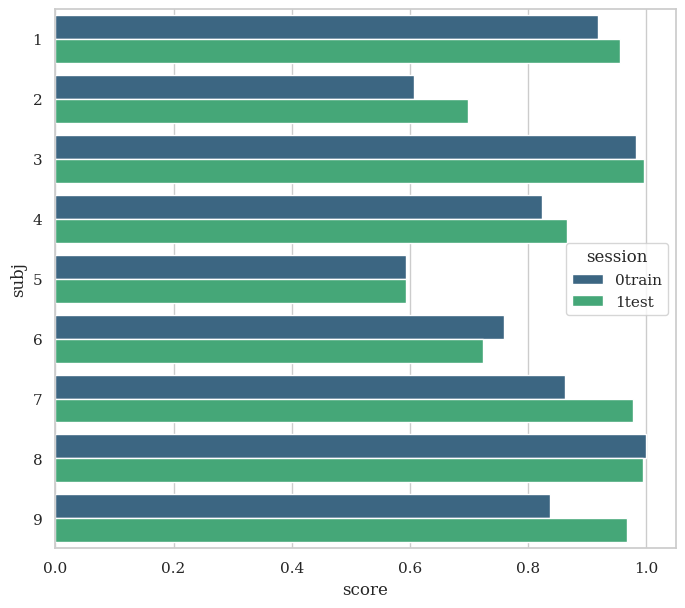

In [14]:
fig, ax = plt.subplots(figsize=(8, 7))
results["subj"] = results["subject"].apply(str)
sns.barplot(
    x="score", y="subj", hue="session", data=results, orient="h", palette="viridis", ax=ax
)
plt.show()